# **Chapter 11 – Training Deep Neural Networks**

This notebook contains my own implementations of code and examples in chapter 11

## Setup

First, let's import a few common modules, ensure `MatplotLib` plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed, as well as Scikit-Learn >= 0.2 and TensorFlow >= 2.0

In [1]:
# Python >= 3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn >= 0.2 is required
import sklearn 
sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow >= 2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Vanishing/Exploding Gradients Problem

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


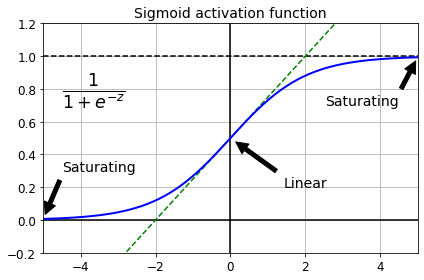

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), 'b-', linewidth=2)
props = dict(facecolor="black", shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, logit(5)), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, logit(-5)), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.annotate(r'$\frac{1}{1 + e^{-z}}$', xy=(-4.5, 0.75), fontsize=25)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

In [4]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [5]:
keras.layers.Dense(10, activation="relu", kernel_initializer=keras.initializers.he_normal)

In [6]:
init = keras.initializers.VarianceScaling(scale=2, mode='fan_avg',
                                         distribution='uniform')
keras.layers.Dense(30, activation="relu", kernel_initializer=init)

## Nonsaturating Activation Functions

## Leaky ReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha * z, z)

Saving figure leaky_relu_plot


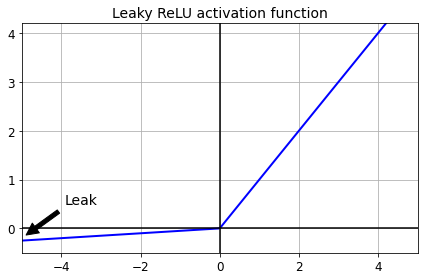

In [8]:
plt.plot(z, leaky_relu(z, 0.05), 'b-', linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
save_fig("leaky_relu_plot", tight_layout=True)
plt.show()

In [9]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [11]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [13]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=keras.optimizers.SGD(learning_rate=1e-3),
             metrics=['accuracy'])

In [14]:
history = model.fit(X_train, y_train, epochs=10,
                   validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.7955 - accuracy: 0.7361 - val_loss: 0.7130 - val_accuracy: 0.7658
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7898
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8066
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5832 - accuracy: 0.8075 - val_loss: 0.5582 - val_accuracy: 0.8200
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5553 - accuracy: 0.8157 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5338 - accuracy: 0.8224 - val_loss: 0.5157 - val_accuracy:

Now let's try PReLU

In [15]:
keras.backend.clear_session()

In [16]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [17]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=keras.optimizers.SGD(learning_rate=1e-3),
             metrics=['accuracy'])

In [18]:
history = model.fit(X_train, y_train, epochs=10,
                   validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.8197 - accuracy: 0.7356 - val_loss: 0.7305 - val_accuracy: 0.7630
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6966 - accuracy: 0.7693 - val_loss: 0.6565 - val_accuracy: 0.7878
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6331 - accuracy: 0.7909 - val_loss: 0.6003 - val_accuracy: 0.8046
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5917 - accuracy: 0.8057 - val_loss: 0.5656 - val_accuracy: 0.8180
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5618 - accuracy: 0.8135 - val_loss: 0.5406 - val_accuracy: 0.8236
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5390 - accuracy: 0.8206 - val_loss: 0.5196 - val_accuracy:

## ELU

In [19]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


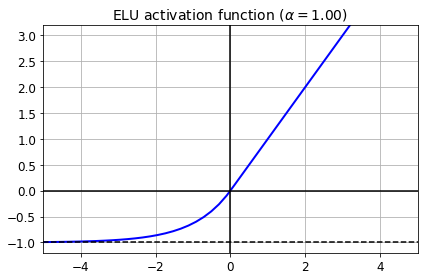

In [20]:
z = np.linspace(-5, 5)
alpha=1
plt.plot(z, elu(z, alpha), 'b-', linewidth=2)
plt.plot([-5, 5], [-alpha, -alpha], 'k--')
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1.2*alpha, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=${:.2f})".format(alpha), fontsize=14)
plt.axis([-5, 5, -1.2*alpha, 3.2])

save_fig("elu_plot")
plt.show()

In [21]:
keras.layers.Dense(10, activation="elu")

## SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Gunter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use $l_1$ or $l_2$ regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [22]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [23]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


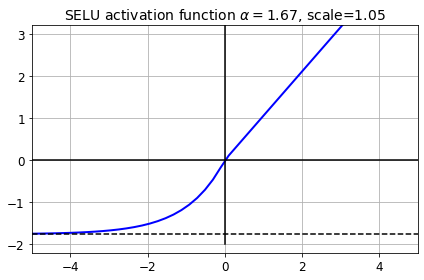

In [24]:
z = np.linspace(-5, 5)
plt.plot(z, selu(z), 'b-', linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0 ,0], [-2, 5], 'k-')
plt.grid(True)
plt.plot([-5, 5], [-alpha_0_1 * scale_0_1, -alpha_0_1 * scale_0_1], 'k--')
plt.title(r"SELU activation function $\alpha=${:.2f}, scale={:.2f}".format(alpha_0_1, scale_0_1), fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standarized with mean 0 and standard deviation 1 too). Using this activation function, evan a 1,000 layer deep neural netowrk preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [25]:
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initalization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation{:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation1.00
Layer 100: mean 0.02, std deviation0.96
Layer 200: mean 0.01, std deviation0.90
Layer 300: mean -0.02, std deviation0.92
Layer 400: mean 0.05, std deviation0.89
Layer 500: mean 0.01, std deviation0.93
Layer 600: mean 0.02, std deviation0.92
Layer 700: mean -0.02, std deviation0.90
Layer 800: mean 0.05, std deviation0.82
Layer 900: mean 0.02, std deviation1.00


Using SELU is easy

In [26]:
keras.layers.Dense(10, activation="selu", kernel_initializer="lecun_normal")

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [27]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [28]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu", 
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [29]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [30]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

### Callbacks

In [31]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [32]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir() + "selu"
run_logdir

'./my_logs/run_2021_07_01-07_09_45selu'

In [33]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=2)

In [34]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                   validation_data=(X_valid_scaled, y_valid),
                   callbacks=[tensorboard_cb, earlystopping_cb])

Epoch 1/5
1719/1719 [==============================] - 33s 18ms/step - loss: 1.2526 - accuracy: 0.5201 - val_loss: 0.8374 - val_accuracy: 0.6820
Epoch 2/5
1719/1719 [==============================] - 30s 17ms/step - loss: 0.7766 - accuracy: 0.7185 - val_loss: 0.6661 - val_accuracy: 0.7670
Epoch 3/5
1719/1719 [==============================] - 30s 18ms/step - loss: 0.6449 - accuracy: 0.7695 - val_loss: 0.6375 - val_accuracy: 0.7754
Epoch 4/5
1719/1719 [==============================] - 30s 18ms/step - loss: 0.6655 - accuracy: 0.7637 - val_loss: 0.5815 - val_accuracy: 0.8062
Epoch 5/5
1719/1719 [==============================] - 30s 17ms/step - loss: 0.5615 - accuracy: 0.8052 - val_loss: 0.5242 - val_accuracy: 0.8172


Now let's look at what happens if we try to use the ReLU activation function instead:

In [35]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [36]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", 
                             kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu",
                                kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [37]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [38]:
run_logdir = get_run_logdir() + "relu"
run_logdir

'./my_logs/run_2021_07_01-07_12_19relu'

In [39]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=2)

In [40]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                   validation_data=(X_valid_scaled, y_valid),
                   callbacks=[tensorboard_cb, earlystopping_cb])

Epoch 1/5
1719/1719 [==============================] - 32s 18ms/step - loss: 1.8421 - accuracy: 0.2502 - val_loss: 1.3505 - val_accuracy: 0.4064
Epoch 2/5
1719/1719 [==============================] - 29s 17ms/step - loss: 1.1745 - accuracy: 0.4915 - val_loss: 0.9987 - val_accuracy: 0.5906
Epoch 3/5
1719/1719 [==============================] - 29s 17ms/step - loss: 0.9601 - accuracy: 0.6017 - val_loss: 0.7938 - val_accuracy: 0.6682
Epoch 4/5
1719/1719 [==============================] - 29s 17ms/step - loss: 0.8250 - accuracy: 0.6677 - val_loss: 0.7341 - val_accuracy: 0.7160
Epoch 5/5
1719/1719 [==============================] - 29s 17ms/step - loss: 0.7536 - accuracy: 0.7010 - val_loss: 0.7046 - val_accuracy: 0.7308


Not great at all, we suffered from the vanishing/exploding gradients problem

# Batch Normalization

In [41]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation='relu', kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='relu', kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='softmax')
])

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_101 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_102 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_103 (Dense)            (None, 10)               

In [43]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [44]:
bn1.updates

/home/asalaheddin/miniconda3/envs/tf-new/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1331: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


[]

In [45]:
model.compile(loss="sparse_categorical_crossentropy", 
             optimizer=keras.optimizers.SGD(learning_rate=1e-3),
             metrics=["accuracy"])

In [46]:
history = model.fit(X_train, y_train, epochs=10,
                   validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.9585 - accuracy: 0.6791 - val_loss: 0.6080 - val_accuracy: 0.7966
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6219 - accuracy: 0.7873 - val_loss: 0.5127 - val_accuracy: 0.8264
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5556 - accuracy: 0.8097 - val_loss: 0.4707 - val_accuracy: 0.8430
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5116 - accuracy: 0.8223 - val_loss: 0.4448 - val_accuracy: 0.8486
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4859 - accuracy: 0.8291 - val_loss: 0.4267 - val_accuracy: 0.8566
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4671 - accuracy: 0.8359 - val_loss: 0.4137 - val_accuracy: 0.8574
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4508 - accuracy: 0.8423 - val_loss: 0.4013 - val_accuracy

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer doesn't need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [47]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [48]:
model.compile(loss="sparse_categorical_crossentropy", 
             optimizer=keras.optimizers.SGD(learning_rate=1e-3),
             metrics=["accuracy"])

In [49]:
history = model.fit(X_train, y_train, epochs=10,
                   validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 1.0882 - accuracy: 0.6649 - val_loss: 0.7203 - val_accuracy: 0.7772
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7110 - accuracy: 0.7716 - val_loss: 0.5956 - val_accuracy: 0.8088
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6263 - accuracy: 0.7937 - val_loss: 0.5363 - val_accuracy: 0.8252
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5728 - accuracy: 0.8080 - val_loss: 0.5012 - val_accuracy: 0.8368
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5375 - accuracy: 0.8157 - val_loss: 0.4753 - val_accuracy: 0.8426
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5154 - accuracy: 0.8231 - val_loss: 0.4561 - val_accuracy: 0.8476
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4971 - accuracy: 0.8303 - val_loss: 0.4410 - val_accuracy

# Gradient Clipping

All keras optimizers accept `clipnorm` or `clipvalue` arguments:

In [50]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [51]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

# Reusing Pretrained Layers

## Reusing a Keras model

Let's split the fashion MNIST training set in two:
- `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6)
- `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using `Dense` layers, only patterns that occure at the same location can be resued (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [52]:
keras.backend.clear_session()

In [53]:
def split_dataset(X, y):
    y_5_or_6 = (y==5) | (y==6) #sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 #class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) #binary classification task: is it a shirt (class 6)?
    return (X[~y_5_or_6], y_A), (X[y_5_or_6], y_B)

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [54]:
X_train_A.shape

(43986, 28, 28)

In [55]:
X_train_B.shape

(200, 28, 28)

In [56]:
y_train_A.shape

(43986,)

In [57]:
y_train_B.shape

(200,)

In [58]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [59]:
np.unique(y_train_A)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint8)

In [60]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [61]:
np.unique(y_train_B)

array([0., 1.], dtype=float32)

In [62]:
tf.random.set_seed(42)
np.random.seed(42)

In [63]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [64]:
model_A.compile(loss="sparse_categorical_crossentropy",
               optimizer=keras.optimizers.SGD(learning_rate=1e-3),
               metrics=["accuracy"])

In [65]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                     validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.5926 - accuracy: 0.8104 - val_loss: 0.3896 - val_accuracy: 0.8662
Epoch 2/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.3523 - accuracy: 0.8785 - val_loss: 0.3288 - val_accuracy: 0.8824
Epoch 3/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.3171 - accuracy: 0.8896 - val_loss: 0.3013 - val_accuracy: 0.8989
Epoch 4/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.2973 - accuracy: 0.8974 - val_loss: 0.2895 - val_accuracy: 0.9023
Epoch 5/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.2835 - accuracy: 0.9020 - val_loss: 0.2776 - val_accuracy: 0.9063
Epoch 6/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.2730 - accuracy: 0.9061 - val_loss: 0.2731 - val_accuracy: 0.9071
Epoch 7/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.2641 - accuracy: 0.9092 - val_loss: 0.2719 - val_accuracy:

In [66]:
model_A.save("my_model_A.h5")

In [67]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [68]:
model_B.compile(loss="binary_crossentropy", 
               optimizer=keras.optimizers.SGD(learning_rate=1e-3),
               metrics=["accuracy"])

In [69]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                     validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 0s 29ms/step - loss: 0.9573 - accuracy: 0.4650 - val_loss: 0.6314 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 18ms/step - loss: 0.5692 - accuracy: 0.7450 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 21ms/step - loss: 0.4503 - accuracy: 0.8650 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 21ms/step - loss: 0.3879 - accuracy: 0.8950 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 21ms/step - loss: 0.3435 - accuracy: 0.9250 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 19ms/step - loss: 0.3081 - accuracy: 0.9300 - val_loss: 0.3019 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 21ms/step - loss: 0.2800 - accuracy: 0.9350 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [===========

In [70]:
model_A = keras.models.load_model("my_model_A.h5")

In [71]:
model_A.layers

In [72]:
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [73]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [74]:
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [75]:
model_B_on_A.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [76]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False
    
model_B_on_A.compile(loss="binary_crossentropy",
                    optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                    metrics=["accuracy"])

In [77]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                          validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True
    
model_B_on_A.compile(loss="binary_crossentropy",
                    optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                    metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                          validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 26ms/step - loss: 0.2651 - accuracy: 0.9400 - val_loss: 0.2798 - val_accuracy: 0.9270
Epoch 2/4
7/7 [==============================] - 0s 19ms/step - loss: 0.2554 - accuracy: 0.9400 - val_loss: 0.2702 - val_accuracy: 0.9300
Epoch 3/4
7/7 [==============================] - 0s 20ms/step - loss: 0.2460 - accuracy: 0.9400 - val_loss: 0.2614 - val_accuracy: 0.9331
Epoch 4/4
7/7 [==============================] - 0s 20ms/step - loss: 0.2375 - accuracy: 0.9400 - val_loss: 0.2532 - val_accuracy: 0.9371
Epoch 1/16
7/7 [==============================] - 0s 30ms/step - loss: 0.2125 - accuracy: 0.9450 - val_loss: 0.2049 - val_accuracy: 0.9635
Epoch 2/16
7/7 [==============================] - 0s 18ms/step - loss: 0.1698 - accuracy: 0.9550 - val_loss: 0.1723 - val_accuracy: 0.9716
Epoch 3/16
7/7 [==============================] - 0s 20ms/step - loss: 0.1408 - accuracy: 0.9700 - val_loss: 0.1496 - val_accuracy: 0.9807
Epoch 4/16
7/7 [===============

So, what's the final verdict?

In [78]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: 0.1408 - accuracy: 0.9705


[0.1408407837152481, 0.9704999923706055]

In [79]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: 0.0563 - accuracy: 0.9940


[0.056322481483221054, 0.9940000176429749]

Great! We got quite a bit of transfer: the error rate dropped by a factor of:

In [80]:
(100 - 0.9704999923706055  * 100) / (100 - 0.9940000176429749 * 100)

4.9166823957164

# Fast Optimizers

In [81]:
[m for m in dir(keras.optimizers) if not m.startswith("_")]

['Adadelta',
 'Adagrad',
 'Adam',
 'Adamax',
 'Ftrl',
 'Nadam',
 'Optimizer',
 'RMSprop',
 'SGD',
 'deserialize',
 'get',
 'schedules',
 'serialize']

## Momentum optimization

In [82]:
optimizer = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

## Nesterov Accelerated Gradient

In [83]:
optimizer = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9, nesterov=True)

## AdaGrad

In [84]:
optimizer = keras.optimizers.Adagrad(learning_rate=1e-3)

## RMSProp

In [85]:
optimizer = keras.optimizers.RMSprop(learning_rate=1e-3, rho=0.9)

## Adam Optimization

In [86]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999)

## Adamax Optimization

In [87]:
optimizer = keras.optimizers.Adamax(learning_rate=1e-3, beta_1=0.9, beta_2=0.999)

## Nadam Optimization

In [88]:
optimizer = keras.optimizers.Nadam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999)

## Learning Rate Scheduling

### Power Scheduling

$$\eta(t) = \frac{\eta_0}{(1 + \frac{t}{s}) ^ c}$$

`lr = lr0 / (1 + steps / s)**c`

* keras uses `c=1` and `s = 1 /decay`

In [89]:
def pow_schedule(t, eta0, s, c):
    return eta0 / (1 + t / s)**c

(0.0, 100000.0, 0.0, 0.0102)

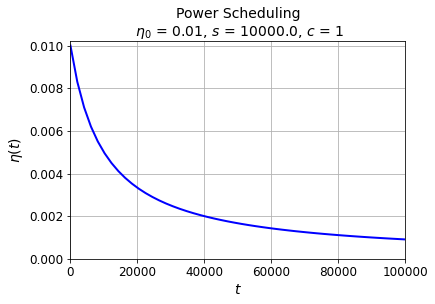

In [90]:
eta0 = 0.01
s = 1 / 1e-4
c = 1
t = np.linspace(0, 100000)

plt.figure()
plt.plot(t, pow_schedule(t, eta0, s, c), 'b', linewidth=2)
plt.title("Power Scheduling\n $\eta_0$ = {}, $s$ = {}, $c$ = {}".format(eta0, s, c),
          fontsize=14)
plt.grid(True)
plt.xlabel("$t$", fontsize=14)
plt.ylabel("$\eta(t)$", fontsize=14)
plt.axis([0, t[-1], 0, eta0 * 1.02])


In [91]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

In [92]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=keras.optimizers.SGD(learning_rate=0.01, decay=1e-4),
              metrics=["accuracy"])

In [93]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid)
                   )

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4898 - accuracy: 0.8270 - val_loss: 0.4065 - val_accuracy: 0.8612
Epoch 2/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3793 - accuracy: 0.8655 - val_loss: 0.3732 - val_accuracy: 0.8698
Epoch 3/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3470 - accuracy: 0.8772 - val_loss: 0.3753 - val_accuracy: 0.8702
Epoch 4/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3262 - accuracy: 0.8844 - val_loss: 0.3514 - val_accuracy: 0.8790
Epoch 5/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3111 - accuracy: 0.8895 - val_loss: 0.3453 - val_accuracy: 0.8774
Epoch 6/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2977 - accuracy: 0.8940 - val_loss: 0.3428 - val_accuracy: 0.8818
Epoch 7/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2876 - accuracy: 0.8979 - val_loss: 0.3384 - val_accuracy:

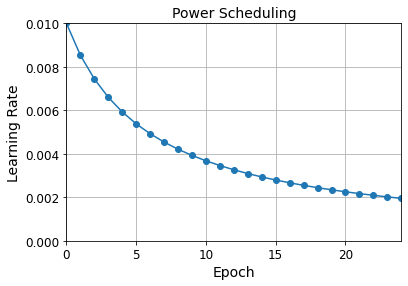

In [94]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs, "o-")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.ylabel("Learning Rate")
plt.xlabel("Epoch")
plt.axis([0, n_epochs - 1, 0, learning_rate])
plt.show()

### Exponential Scheduling

$$\eta(t) = \eta_0 0.1 ^ {\frac{t}{s}}$$

`lr = lr0 * 0.1**(epochs / s)`

In [95]:
def expo_schedule(t, eta0, s):
    return eta0 * 0.1**(t / s)

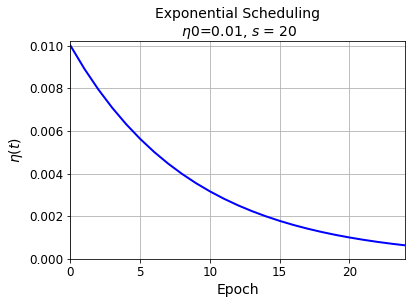

In [96]:
eta0 = 0.01
s = 20
t = np.arange(25)

plt.figure()
plt.plot(t, expo_schedule(t, eta0, s), 'b', linewidth=2)
plt.title("Exponential Scheduling\n $\eta0$={}, $s$ = {}".format(eta0, s),
         fontsize=14)
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("$\eta(t)$")
plt.axis([0, t[-1], 0, eta0 * 1.02])
plt.show()

In [97]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [98]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn


exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [99]:
keras.backend.clear_session()

In [100]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="nadam",
              metrics=["accuracy"]
             )

In [101]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn, verbose=1)

In [102]:
n_epochs = 25

history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler]
                   )

Epoch 1/25

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
1719/1719 [==============================] - 9s 5ms/step - loss: 1.4402 - accuracy: 0.7193 - val_loss: 0.9787 - val_accuracy: 0.7662
Epoch 2/25

Epoch 00002: LearningRateScheduler reducing learning rate to 0.008912509381337455.
1719/1719 [==============================] - 9s 5ms/step - loss: 0.9347 - accuracy: 0.7762 - val_loss: 0.7193 - val_accuracy: 0.8258
Epoch 3/25

Epoch 00003: LearningRateScheduler reducing learning rate to 0.007943282347242816.
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7557 - accuracy: 0.8029 - val_loss: 0.9779 - val_accuracy: 0.7470
Epoch 4/25

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0070794578438413795.
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6933 - accuracy: 0.8136 - val_loss: 0.6535 - val_accuracy: 0.8296
Epoch 5/25

Epoch 00005: LearningRateScheduler reducing learning rate to 0.006309573444801933.
1719/171

In [103]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [104]:
history.history['lr'][-1]

0.00063095737

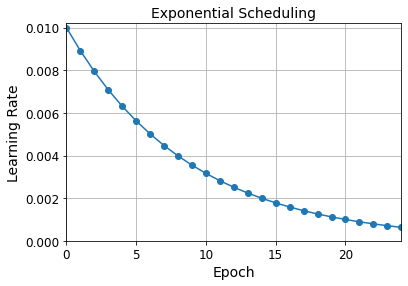

In [105]:
plt.plot(history.epoch, history.history['lr'], 'o-')
plt.grid(True)
plt.title("Exponential Scheduling", fontsize=14)
plt.ylabel("Learning Rate")
plt.xlabel("Epoch")
plt.axis([0, history.epoch[-1], 0, history.history['lr'][0] * 1.02])
plt.show()

The schedule function can take the current learning rate as a second argument:

In [106]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [107]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s
        
    def on_batch_begin(self, batch, logs=None):
        # Note: the 'batch' argument is reset at each epoch
        lr = keras.backend.get_value(self.model.optimizer.lr)
        keras.backend.set_value(self.model.optimizer.lr, lr * 0.1**(1 /s))
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = keras.backend.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"],              
             )

n_epochs =25
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size =32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train,
                    epochs=n_epochs,
                    callbacks=[exp_decay],
                    validation_data=(X_valid_scaled, y_valid)
                   )

Epoch 1/25
1719/1719 [==============================] - 11s 6ms/step - loss: 1.2820 - accuracy: 0.7317 - val_loss: 0.9726 - val_accuracy: 0.7356
Epoch 2/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.9003 - accuracy: 0.7839 - val_loss: 0.7191 - val_accuracy: 0.8068
Epoch 3/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6987 - accuracy: 0.8152 - val_loss: 0.8678 - val_accuracy: 0.7796
Epoch 4/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6007 - accuracy: 0.8302 - val_loss: 0.6303 - val_accuracy: 0.8376
Epoch 5/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5554 - accuracy: 0.8416 - val_loss: 0.5617 - val_accuracy: 0.8320
Epoch 6/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4920 - accuracy: 0.8527 - val_loss: 0.4885 - val_accuracy: 0.8640
Epoch 7/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4527 - accuracy: 0.8645 - val_loss: 0.5168 - val_ac

In [108]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

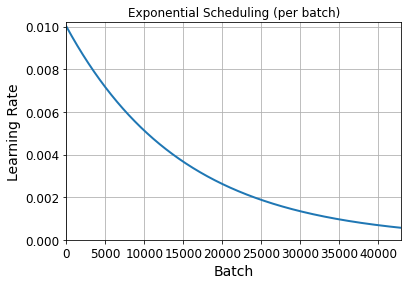

In [109]:
plt.plot(steps, lrs, '-', linewidth=2)
plt.title("Exponential Scheduling (per batch)")
plt.ylabel("Learning Rate")
plt.xlabel("Batch")
plt.grid(True)
plt.axis([0, steps[-1], 0, lrs[0] * 1.02])
plt.show()

### Piecewise Constant Scheduling

In [110]:
keras.backend.clear_session()

In [111]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [112]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [113]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Nadam(),
              metrics=["accuracy"]
             )

In [114]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn, verbose=1)
history = model.fit(X_train_scaled, y_train,
          epochs = 25,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=[lr_scheduler]
         )

Epoch 1/25

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
1719/1719 [==============================] - 9s 5ms/step - loss: 1.4468 - accuracy: 0.7160 - val_loss: 1.6859 - val_accuracy: 0.7074
Epoch 2/25

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
1719/1719 [==============================] - 9s 5ms/step - loss: 1.2376 - accuracy: 0.7365 - val_loss: 0.9439 - val_accuracy: 0.7740
Epoch 3/25

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
1719/1719 [==============================] - 9s 5ms/step - loss: 1.1693 - accuracy: 0.7402 - val_loss: 2.5340 - val_accuracy: 0.6420
Epoch 4/25

Epoch 00004: LearningRateScheduler reducing learning rate to 0.01.
1719/1719 [==============================] - 9s 5ms/step - loss: 1.2196 - accuracy: 0.7232 - val_loss: 1.2863 - val_accuracy: 0.7250
Epoch 5/25

Epoch 00005: LearningRateScheduler reducing learning rate to 0.01.
1719/1719 [==============================] - 9s 5ms/step - loss: 1.1543 -

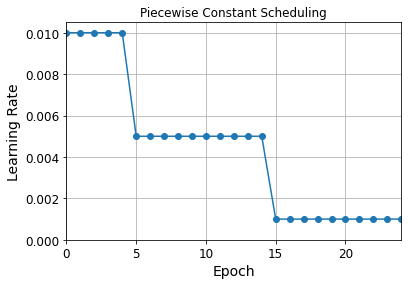

In [115]:
plt.figure()
plt.plot(history.epoch, history.history["lr"], "o-")
plt.title("Piecewise Constant Scheduling")
plt.ylabel("Learning Rate")
plt.xlabel("Epoch")
plt.axis([0, history.epoch[-1], 0, history.history["lr"][0]*1.05])
plt.grid(True)
plt.show()

### Performance Scheduling

In [116]:
tf.random.set_seed(42)
np.random.seed(42)
keras.backend.clear_session()

In [117]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")    
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=0.02, momentum=0.9),
              metrics=["accuracy"]
)


In [118]:
history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_valid_scaled, y_valid),
                    epochs=25,
                    callbacks=[lr_scheduler]
                   )

Epoch 1/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5870 - accuracy: 0.8071 - val_loss: 0.4493 - val_accuracy: 0.8530
Epoch 2/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4946 - accuracy: 0.8400 - val_loss: 0.6494 - val_accuracy: 0.8318
Epoch 3/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5117 - accuracy: 0.8420 - val_loss: 0.4970 - val_accuracy: 0.8536
Epoch 4/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5058 - accuracy: 0.8471 - val_loss: 0.5163 - val_accuracy: 0.8548
Epoch 5/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5167 - accuracy: 0.8510 - val_loss: 0.6329 - val_accuracy: 0.8338
Epoch 6/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5158 - accuracy: 0.8525 - val_loss: 0.5202 - val_accuracy: 0.8494

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.009999999776482582.
Epoch 7/25
1719/1719 [==============================] - 

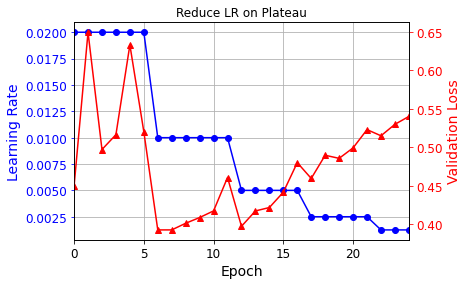

In [119]:
plt.figure()
plt.plot(history.epoch, history.history["lr"], 'bo-')
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color="b")
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, history.epoch[-1])
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], 'r^-')
ax2.set_ylabel("Validation Loss", color="r")
ax2.tick_params('y', colors="r")

plt.title("Reduce LR on Plateau")
plt.show()

### tf.keras schedulers

In [120]:
[m for m in dir(tf.keras.optimizers.schedules) if not m.startswith("__")]

['CosineDecay',
 'CosineDecayRestarts',
 'ExponentialDecay',
 'InverseTimeDecay',
 'LearningRateSchedule',
 'PiecewiseConstantDecay',
 'PolynomialDecay',
 '_sys',
 'deserialize',
 'serialize']

In [121]:
keras.backend.clear_session()

In [122]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate),
              metrics=["accuracy"]
             )

history = model.fit(X_train_scaled, y_train,
                    epochs=25,
                    validation_data=(X_valid_scaled, y_valid)
                   )

Epoch 1/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4894 - accuracy: 0.8274 - val_loss: 0.4092 - val_accuracy: 0.8604
Epoch 2/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3820 - accuracy: 0.8651 - val_loss: 0.3738 - val_accuracy: 0.8692
Epoch 3/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3487 - accuracy: 0.8764 - val_loss: 0.3731 - val_accuracy: 0.8692
Epoch 4/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3263 - accuracy: 0.8837 - val_loss: 0.3493 - val_accuracy: 0.8802
Epoch 5/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3103 - accuracy: 0.8895 - val_loss: 0.3429 - val_accuracy: 0.8794
Epoch 6/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2958 - accuracy: 0.8952 - val_loss: 0.3414 - val_accuracy: 0.8814
Epoch 7/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2854 - accuracy: 0.8988 - val_loss: 0.3354 - val_accuracy:

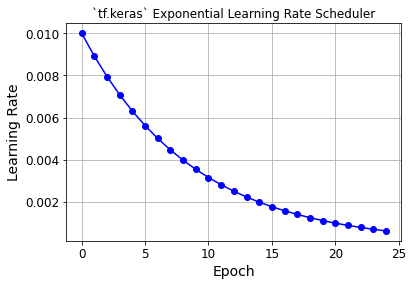

In [123]:
plt.figure()
plt.plot(history.epoch, 
         [history.model.optimizer.learning_rate(m * len(X_train) // 32) for m in history.epoch]
         , 'bo-')
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("`tf.keras` Exponential Learning Rate Scheduler")
plt.grid(True)
plt.show()

For piecewise constant scheduling, try this:

In [124]:
keras.backend.clear_session()

In [125]:
n_steps_per_epoch = len(X_train) // 32
learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay( 
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001]
)

In [126]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate),
              metrics=["accuracy"]
             )

history = model.fit(X_train_scaled, y_train,
                    epochs=25,
                    validation_data=(X_valid_scaled, y_valid)
                   )

Epoch 1/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2494 - accuracy: 0.9093 - val_loss: 0.3305 - val_accuracy: 0.8802
Epoch 2/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2394 - accuracy: 0.9130 - val_loss: 0.3231 - val_accuracy: 0.8846
Epoch 3/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2294 - accuracy: 0.9161 - val_loss: 0.3524 - val_accuracy: 0.8758
Epoch 4/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2206 - accuracy: 0.9201 - val_loss: 0.3257 - val_accuracy: 0.8878
Epoch 5/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2142 - accuracy: 0.9214 - val_loss: 0.3182 - val_accuracy: 0.8884
Epoch 6/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.1880 - accuracy: 0.9340 - val_loss: 0.3194 - val_accuracy: 0.8886
Epoch 7/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.1833 - accuracy: 0.9353 - val_loss: 0.3226 - val_accuracy:

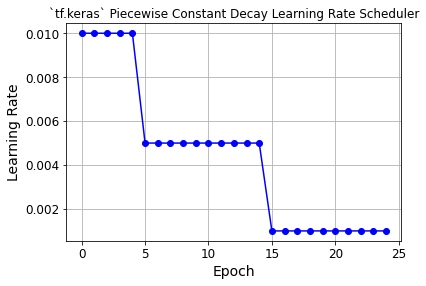

In [127]:
plt.figure()
plt.plot(history.epoch, 
         [history.model.optimizer.learning_rate(m * len(X_train) // 32) for m in history.epoch]
         , 'bo-')
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title(r"`tf.keras` Piecewise Constant Decay Learning Rate Scheduler")
plt.grid(True)
plt.show()

### 1Cycle scheduling

In [128]:
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(keras.backend.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        keras.backend.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)
        
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    initial_lr = keras.backend.get_value(model.optimizer.lr)    
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    keras.backend.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                       callbacks=[exp_lr])
    keras.backend.set_value(model.optimizer.lr, initial_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [129]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"]
             )

430/430 [==============================] - 2s 5ms/step - loss: nan - accuracy: 0.3953


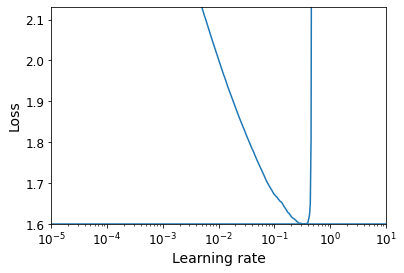

In [130]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [131]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
               / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                    self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                    self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        keras.backend.set_value(self.model.optimizer.lr, rate)

In [132]:
n_epochs = 25
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                   validation_data=(X_valid_scaled, y_valid), 
                   callbacks=[onecycle])

Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5140 - accuracy: 0.8197 - val_loss: 0.4228 - val_accuracy: 0.8542
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3987 - accuracy: 0.8576 - val_loss: 0.3762 - val_accuracy: 0.8692
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3619 - accuracy: 0.8691 - val_loss: 0.4433 - val_accuracy: 0.8400
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3087 - accuracy: 0.8864 - val_loss: 0.3300 - val_accuracy: 0.8816
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2600 - accuracy: 0.9051 - val_loss: 0.3126 - val_accuracy: 0.8884
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2233 - accuracy: 0.9205 - val_loss: 0.3042 - val_accuracy: 0.8910
Epoch 7/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2085 - accuracy: 0.9260 - val_loss: 0.3051 - val_accuracy:

# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

In [133]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01)
                          )

# or l1(0.1) for l1 regularization with a factor of 0.1
# or l1_l2(0.1, 0.01) for both l1 and l2 regularization with factors 0.1 and 0.01 respectively

In [134]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu", 
                       kernel_initializer="he_normal", 
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu", 
                       kernel_initializer="he_normal", 
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax", 
                       kernel_regularizer=keras.regularizers.l2(0.01)),    
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Nadam(),
              metrics=["accuracy"]
             )

n_epochs = 2
history = model.fit(X_train_scaled, y_train,
                    epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid)
                   )

Epoch 1/2
1719/1719 [==============================] - 9s 5ms/step - loss: 1.5956 - accuracy: 0.8124 - val_loss: 0.7169 - val_accuracy: 0.8340
Epoch 2/2
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7197 - accuracy: 0.8274 - val_loss: 0.6850 - val_accuracy: 0.8376


In [135]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01)
                          )

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
             optimizer=keras.optimizers.Nadam(),
             metrics=["accuracy"])

n_epochs = 2
history = model.fit(X_train_scaled, y_train,
                    epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 9s 5ms/step - loss: 1.6313 - accuracy: 0.8113 - val_loss: 0.7218 - val_accuracy: 0.8310
Epoch 2/2
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7187 - accuracy: 0.8273 - val_loss: 0.6826 - val_accuracy: 0.8382


## Dropout

In [136]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),    
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=2,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5838 - accuracy: 0.7998 - val_loss: 0.3730 - val_accuracy: 0.8642
Epoch 2/2
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4209 - accuracy: 0.8441 - val_loss: 0.3416 - val_accuracy: 0.8724


## Alpha Droput

In [137]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [138]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),    
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),    
    keras.layers.Dense(10, activation="softmax")
])

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=25,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6641 - accuracy: 0.7594 - val_loss: 0.5778 - val_accuracy: 0.8446
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5565 - accuracy: 0.7946 - val_loss: 0.5146 - val_accuracy: 0.8536
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5203 - accuracy: 0.8081 - val_loss: 0.4904 - val_accuracy: 0.8610
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5083 - accuracy: 0.8119 - val_loss: 0.4845 - val_accuracy: 0.8600
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4950 - accuracy: 0.8181 - val_loss: 0.4265 - val_accuracy: 0.8672
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4830 - accuracy: 0.8201 - val_loss: 0.4567 - val_accuracy: 0.8646
Epoch 7/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4724 - accuracy: 0.8238 - val_loss: 0.4682 - val_accuracy:

In [139]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.5302 - accuracy: 0.8657


[0.53021240234375, 0.8657000064849854]

In [140]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 5s 3ms/step - loss: 0.4024 - accuracy: 0.8848


[0.4024091958999634, 0.8848000168800354]

In [141]:
history = model.fit(X_train_scaled, y_train)

1719/1719 [==============================] - 7s 4ms/step - loss: 0.4062 - accuracy: 0.8490


## MC Dropout

In [142]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [143]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])

y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [144]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.97]],
      dtype=float32)

In [145]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.26, 0.  , 0.62]],
      dtype=float32)

In [146]:
y_test[0]

9

In [147]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.28, 0.  , 0.69]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.89, 0.  , 0.07]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.5 , 0.  , 0.01, 0.  , 0.49]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.84, 0.  , 0.14]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.33, 0.  , 0.67]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.68, 0.  , 0.3 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.31, 0.  , 0.61]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.97]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.3 , 0.  , 0.13, 0.  , 0.57]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.01, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.16, 0.  , 0.81]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.24, 0.  , 0.17, 0.  , 0.59]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.46, 0.  , 0.5 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.21, 0.  , 0.33, 0.  , 0

In [148]:
y_std = y_probas.std(axis=0)

In [149]:
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.17, 0.03, 0.23, 0.  , 0.27]],
      dtype=float32)

In [150]:
y_pred = np.argmax(y_proba, axis=1)

In [151]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8714

In [152]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [153]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [154]:
mc_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
mc_alpha_dropout (MCAlphaDro (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
mc_alpha_dropout_1 (MCAlphaD (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
mc_alpha_dropout_2 (MCAlphaD (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

In [155]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy",
                 optimizer=optimizer,
                 metrics=["accuracy"]
                )

In [156]:
mc_model.set_weights(model.get_weights())

Now we can use the model with MC Dropout

In [157]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.13, 0.  , 0.31, 0.  , 0.56]],
      dtype=float32)

## Max norm

In [158]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [159]:
from functools import partial

MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                   validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4749 - accuracy: 0.8339 - val_loss: 0.3745 - val_accuracy: 0.8622
Epoch 2/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3542 - accuracy: 0.8706 - val_loss: 0.3821 - val_accuracy: 0.8676
Epoch 3/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3282 - accuracy: 0.8787 - val_loss: 0.3575 - val_accuracy: 0.8706
Epoch 4/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3175 - accuracy: 0.8821 - val_loss: 0.3398 - val_accuracy: 0.8788
Epoch 5/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3119 - accuracy: 0.8832 - val_loss: 0.3216 - val_accuracy: 0.8832
Epoch 6/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3067 - accuracy: 0.8863 - val_loss: 0.3393 - val_accuracy: 0.8796
Epoch 7/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3069 - accuracy: 0.8863 - val_loss: 0.3445 - val_accuracy:

# Exercises

# 8. Deep Learning on CIFAR10